In [9]:
import fasttext
import fasttext.util
import numpy as np
import matplotlib.pyplot as plt
import umap
import hdbscan
import nltk
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA, TruncatedSVD, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
import pandas as pd
import re
import seaborn as sns
nltk.download("stopwords")


#fasttext.util.download_model('ru', if_exists='ignore')  
#ft = fasttext.load_model('cc.ru.300.bin')
#fasttext.util.reduce_model(ft, 100)


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/thelightdashing/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
df = pd.read_csv("lenta-ru-news.csv")
df.head(5)

/home/thelightdashing/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,url,title,text,topic,tags,date
0,https://lenta.ru/news/1914/09/16/hungarnn/,1914. Русские войска вступили в пределы Венгрии,Бои у Сопоцкина и Друскеник закончились отступ...,Библиотека,Первая мировая,1914/09/16
1,https://lenta.ru/news/1914/09/16/lermontov/,1914. Празднование столетия М.Ю. Лермонтова от...,"Министерство народного просвещения, в виду про...",Библиотека,Первая мировая,1914/09/16
2,https://lenta.ru/news/1914/09/17/nesteroff/,1914. Das ist Nesteroff!,"Штабс-капитан П. Н. Нестеров на днях, увидев в...",Библиотека,Первая мировая,1914/09/17
3,https://lenta.ru/news/1914/09/17/bulldogn/,1914. Бульдог-гонец под Льежем,Фотограф-корреспондент Daily Mirror рассказыва...,Библиотека,Первая мировая,1914/09/17
4,https://lenta.ru/news/1914/09/18/zver/,1914. Под Люблином пойман швабский зверь,"Лица, приехавшие в Варшаву из Люблина, передаю...",Библиотека,Первая мировая,1914/09/18


In [11]:
df.isna().sum()

url          0
title        0
text         5
topic    62002
tags     27219
date         0
dtype: int64

In [4]:
df.dropna(subset=["topic", 'tags', 'text'], inplace=True)
df.isna().sum()
df = df.drop(columns=["url", "topic", "tags", "title"])

In [34]:
df['topic'].value_counts()

Россия               155004
Мир                  136620
Экономика             76423
Спорт                 57894
Культура              53530
Наука и техника       53136
Бывший СССР           51370
Интернет и СМИ        44421
Из жизни              27513
Дом                   21734
Силовые структуры     11223
Ценности               7581
Бизнес                 7375
Путешествия            6370
69-я параллель         1268
Крым                    666
Культпросвет            340
Легпром                 114
Библиотека               65
Оружие                    3
ЧМ-2014                   2
Сочи                      1
МедНовости                1
Name: topic, dtype: int64

Давайте попробуем использовать LDA для начала

In [10]:
patterns = r"[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
stopwords_ru = stopwords.words("russian")
morph = MorphAnalyzer()
data = pd.DataFrame()

def lemmatize(doc):
    doc = re.sub(patterns, ' ', doc)
    words = nltk.word_tokenize(doc)
    words = [word for word in words if not word in stopwords_ru]
    if len(words) > 2:        
        return " ".join(words)
    return None

data_text = df['text'].apply(lemmatize)
data_text.dropna(inplace=True)

tfidf = TfidfVectorizer(max_features=1000)
data_tfidf = tfidf.fit_transform(data_text)

In [39]:
lda = LatentDirichletAllocation(10, n_jobs=3, learning_method='online', random_state=42)
lda.fit(data_tfidf)

LatentDirichletAllocation(learning_method='online', n_jobs=3, random_state=42)

In [40]:
lda_topics = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

def get_model_topics(model, vectorizer, topics, n_top_words=20):
    word_dict = {}
    feature_names = vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        word_dict[topics[topic_idx]] = top_features

    return pd.DataFrame(word_dict)

results_df = get_model_topics(lda, tfidf, lda_topics)

In [41]:
results_df

,0,1,2,3,4,5,6,7,8,9
0,году,ленты,процента,сборной,суд,человек,россии,сша,южной,самолет
1,года,ру,рублей,чемпионата,счетом,по,украины,страны,боевиков,самолета
2,также,фильма,процентов,мира,дело,мужчина,года,оон,сил,газа
3,видео,фильм,долларов,команды,матче,результате,заявил,нато,обороны,авиакомпании
4,это,актер,евро,лиги,матч,полиции,это,против,ракеты,борту
5,об,аль,миллиардов,клуба,матча,сообщает,также,власти,группировки,появилась
6,долларов,турции,миллиона,клуб,дела,данным,об,телеканал,армии,пассажиров
7,компания,роль,года,место,рублей,об,президент,стран,военных,самолетов
8,лет,университета,компании,тренер,суда,произошел,по,ес,боевики,газ
9,сша,премии,рубля,россии,делу,области,президента,заявил,военные,аэропорту


In [44]:
def vectorize(doc):
    vector = ft.get_sentence_vector(doc)
    return vector

data_vectors = data_text.apply(vectorize)

In [50]:
km = MiniBatchKMeans(init='k-means++', n_init=1, init_size=1000, batch_size=1000)
km.fit(data_vectors.values.tolist())

MiniBatchKMeans(batch_size=1000, init_size=1000, n_init=1)

In [ ]:
standard_embedding = umap.UMAP(random_state=42).fit_transform(data_tfidf)

In [12]:
data_umapped = umap.UMAP(n_neighbors=30,
    min_dist=0.0,
    n_components=2,
    random_state=42,
).fit_transform(data_tfidf)


In [13]:
labels = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=500,
).fit_predict(data_umapped)

In [14]:
clustered = (labels >= 0)
plt.scatter(standard_embedding[~clustered, 0],
            standard_embedding[~clustered, 1],
            c=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(standard_embedding[clustered, 0],
            standard_embedding[clustered, 1],
            c=labels[clustered],
            s=0.1,
            cmap='Spectral');

NameError: name 'standard_embedding' is not defined

/home/thelightdashing/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

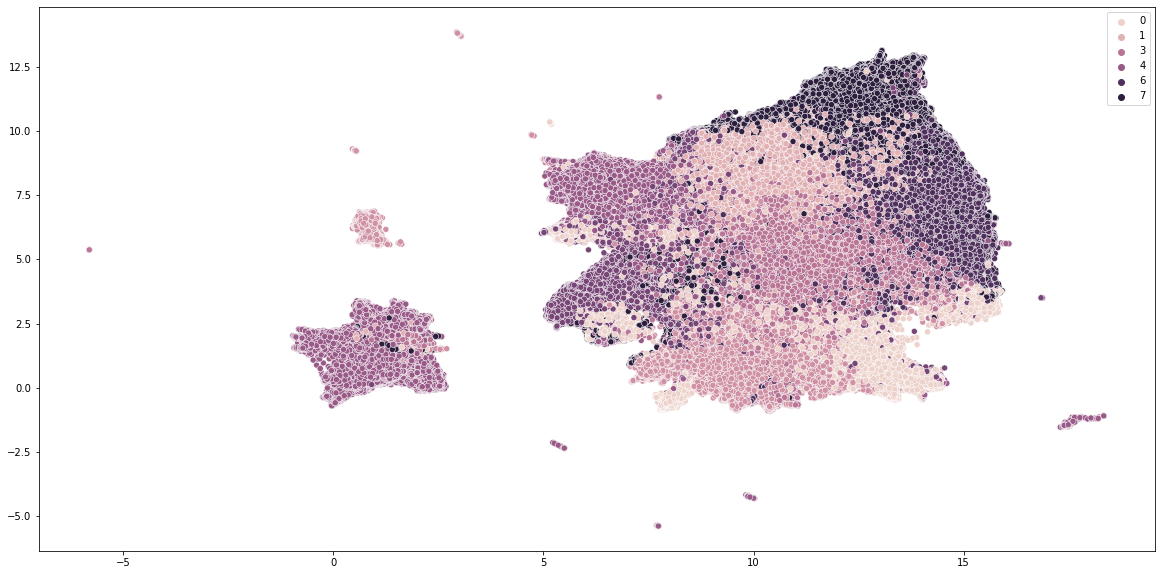

In [71]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.scatterplot(data_umapped[:, 0], data_umapped[:, 1], hue=km.labels_)

In [ ]:
terms = tfidf.get_feature_names()
    for i in range(true_k):
        print("Cluster %d:" % i, end='')
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind], end='')
        print()